In [ ]:
import getpass
import os

if "GROQ_API_KEY" not in os.environ:

    
    os.environ["GROQ_API_KEY"] = getpass.getpass("")

In [ ]:
os.environ["GROQ_API_KEY"] = ""

In [3]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="openai/gpt-oss-120b")

In [4]:

ai_msg = llm.invoke("hi")
ai_msg.content

'Hello! How can I help you today?'

In [18]:
print(ai_msg.content)

Hello! How can I help you today?


In [19]:
import sys, os

# Get project root — one level up from 'research_and_analyst'
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: h:\akash\git\CoherenceAI


In [21]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage,HumanMessage , SystemMessage
from langgraph.checkpoint.memory import MemorySaver

In [22]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [34]:
class RequirementDescription(BaseModel):
    description: str = Field(description="Description of the requirement.")

    
    @property
    def persona(self) -> str:
        return f"description: {self.description}\\n"
    

In [35]:
desc = RequirementDescription(
    description="Mobile manufactruring"
    )

In [36]:
desc.persona

'description: Mobile manufactruring\\n'

In [37]:
desc.description

'Mobile manufactruring'

In [39]:

class Perspectives(BaseModel):
       descriptions: List[RequirementDescription] = Field(description="Comprehensive list of requiremnent Descriptions.")

In [40]:
class GenerateDescriptionState(TypedDict):
    topic: str

In [44]:
from typing import List, TypedDict, Annotated
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, MessagesState, END
from pydantic import BaseModel, Field

In [45]:

# -----------------------------
# 1️⃣ Pydantic model for output
# -----------------------------
class KeywordOutput(BaseModel):
    """Structured keyword output model."""
    keywords: List[str] = Field(..., description="List of 5 keywords, each 3 words long")


In [46]:


# -----------------------------
# 2️⃣ Define the State
# -----------------------------
class KeywordState(MessagesState):
    """State of the keyword generation graph."""
    requirement_description: str  # user input
    keyword_output: KeywordOutput  # structured LLM output



In [47]:
# Structured output binding
llm_structured = llm.with_structured_output(KeywordOutput)

In [48]:

prompt = ChatPromptTemplate.from_template("""
You are an expert requirement analyst.  
Given the following requirement description:

"{requirement_description}"

Generate exactly 5 *keywords*, each containing 3 words, that best summarize the requirement.

Return them as a JSON list of strings.
""")


In [49]:
def generate_keywords(state: KeywordState):
    """Generate structured keywords using LLM."""
    chain = prompt | llm_structured
    result = chain.invoke({"requirement_description": state["requirement_description"]})

    # ✅ Do NOT append manually — LangGraph already tracks messages
    state["keyword_output"] = result
    return state

In [50]:

# -----------------------------
# 4️⃣ Build the LangGraph
# -----------------------------
graph = StateGraph(KeywordState)
graph.add_node("generate_keywords", generate_keywords)
graph.add_edge("generate_keywords", END)
graph.set_entry_point("generate_keywords")

app = graph.compile()

In [51]:
memory = MemorySaver()

In [52]:
graph = graph.compile(checkpointer= memory)

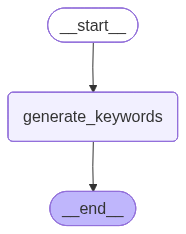

In [53]:
from langgraph.graph import StateGraph, MessagesState, END
from IPython.display import Image, display



from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))


In [54]:
from langchain_core.messages import SystemMessage

topic = "The new smartphone shall feature a 6.7-inch AMOLED display, octa-core processor, and 5G connectivity"
max_keywords = 5

# Optional thread config for isolation
thread = {"configurable": {"thread_id": 1}}

# Stream events from the graph
for event in graph.stream(
    {"requirement_description": topic},
    thread,
    stream_mode="values"  # stream actual outputs
):
    # 'keyword_output' may or may not exist yet
    keyword_output = event.get("keyword_output", None)
    messages = event.get("messages", [])

    # Print messages as they arrive
    if messages:
        for m in messages:
            print(f"[{m.type}] {m.content}")

    # Print partial keywords if available
    if keyword_output:
        print("\n⚡ Current Keywords Generated:")
        for kw in keyword_output.keywords:
            print(f" - {kw}")
        print("-" * 50)



⚡ Current Keywords Generated:
 - 6.7-inch AMOLED display
 - Octa-core CPU processor
 - 5G connectivity support
 - High resolution display
 - Advanced mobile chipset
--------------------------------------------------


In [55]:
# user_input = input("Enter your requirement description: ")
user_input = "The new smartphone shall feature a 6.7-inch AMOLED display with a resolution of at least 2400x1080 pixels, offering vibrant colors and a 120Hz refresh rate for smooth visual performance. It shall be powered by an octa-core processor with a minimum clock speed of 3.0 GHz and supported by at least 8GB of RAM to ensure seamless multitasking. The device shall include 256GB of internal storage, expandable up to 1TB via microSD. A triple-lens rear camera system with 108MP primary, 12MP ultra-wide, and 10MP telephoto lenses shall enable high-quality imaging under various lighting conditions. The front camera shall be at least 32MP for high-resolution selfies and video calls. The smartphone shall support 5G, Wi-Fi 6, and Bluetooth 5.3 connectivity for high-speed data transfer. It shall include a 5000mAh battery supporting 65W fast charging to achieve 50% charge within 20 minutes. The operating system shall be Android 14 or equivalent, with guaranteed security updates for at least three years. The chassis shall be made of reinforced aluminum with Gorilla Glass Victus protection for durability. Additionally, the device shall comply with IP68 standards for dust and water resistance."
initial_state = {"requirement_description": user_input, "messages": []}

print("\n⚙️ Running the LangGraph pipeline...")
final_state = app.invoke(initial_state)

# ✅ Structured output
print("\n✅ Generated Keywords:")
for kw in final_state["keyword_output"].keywords:
    print(" -", kw)

# ✅ State
print("\n📦 Final State:")
print(final_state)

print("\n💬 Message History:")
for m in final_state["messages"]:
    # Works for HumanMessage, SystemMessage, AIMessage etc.
    print(f"[{m.type}] {m.content}")
    



⚙️ Running the LangGraph pipeline...

✅ Generated Keywords:
 - 6.7-inch AMOLED display
 - Octa-core 3.0GHz processor
 - 256GB expandable storage
 - 108MP triple-camera system
 - 5000mAh 65W charging

📦 Final State:
{'messages': [], 'requirement_description': 'The new smartphone shall feature a 6.7-inch AMOLED display with a resolution of at least 2400x1080 pixels, offering vibrant colors and a 120Hz refresh rate for smooth visual performance. It shall be powered by an octa-core processor with a minimum clock speed of 3.0 GHz and supported by at least 8GB of RAM to ensure seamless multitasking. The device shall include 256GB of internal storage, expandable up to 1TB via microSD. A triple-lens rear camera system with 108MP primary, 12MP ultra-wide, and 10MP telephoto lenses shall enable high-quality imaging under various lighting conditions. The front camera shall be at least 32MP for high-resolution selfies and video calls. The smartphone shall support 5G, Wi-Fi 6, and Bluetooth 5.3 co

In [56]:
final_state["keyword_output"].keywords

['6.7-inch AMOLED display',
 'Octa-core 3.0GHz processor',
 '256GB expandable storage',
 '108MP triple-camera system',
 '5000mAh 65W charging']

In [71]:
def reset_state():
    """Reset the LangGraph KeywordState to an empty baseline."""
    return {
        "requirement_description": "",
        "messages": [],
        "keyword_output": None
    }

# Usage
state = reset_state()

In [57]:
result

NameError: name 'result' is not defined

In [58]:
initial_state["messages"]

[]

In [59]:
result["keyword_output"].keywords

NameError: name 'result' is not defined

In [60]:
print("\n✅ Generated Keywords:")
for k in result["keyword_output"].keywords:
    print(f" - {k}")


✅ Generated Keywords:


NameError: name 'result' is not defined

In [61]:
class Risk (BaseModel):
    risk: str = Field(description="A risk associated with the requirement.")


In [62]:
class Requirements(BaseModel):
    requirement: str = Field(description="Requirement that needs to be generated.")
    priority: str = Field(description="Role of the analyst in the context of the topic.")
    analysts: List[Risk] = Field(description="Comprehensive list of analysts with their roles and affiliations.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    

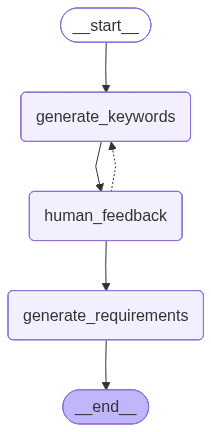

In [172]:
from langgraph.graph import StateGraph, MessagesState, END

from langchain_core.messages import SystemMessage
from pydantic import BaseModel, Field
from typing import List
from langgraph.checkpoint.memory import MemorySaver
# -----------------------------
# Pydantic Models
# -----------------------------
class KeywordOutput(BaseModel):
    keywords: List[str] = Field(..., description="5 keywords, each 3 words long")

class RequirementsOutput(BaseModel):
    requirements: List[str] = Field(..., description="5 formal requirements derived from selected keyword")


# -----------------------------
# Graph State
# -----------------------------
class KeywordState(MessagesState):
    requirement_description: str
    keyword_output: KeywordOutput | None = None
    selected_keyword: str | None = None
    requirements_output: RequirementsOutput | None = None


# -----------------------------
# Nodes (example placeholders)
# -----------------------------
def generate_keywords(state: KeywordState):
    # LLM call logic here

    from langchain_core.prompts import ChatPromptTemplate


    prompt = ChatPromptTemplate.from_template("""
    You are an expert requirement analyst.  
    Given the following requirement description:

    "{requirement_description}"

    Generate exactly 5 keywords, each containing 3 words, as JSON list.
    """)

    # Use structured output
    llm_structured = llm.with_structured_output(KeywordOutput)
    result = (prompt | llm_structured).invoke({"requirement_description": state["requirement_description"]})

    state["keyword_output"] = result
    state["messages"].append(SystemMessage(content=f"Generated keywords: {result.keywords}"))


    print("=== Current State ===")
    for k, v in state.items():
        print(f"{k}: {v}")
    return state


def human_feedback(state: KeywordState):
    """Interrupt node: user selects keyword"""
    print("\n✅ Generated Keywords:")
    for i, kw in enumerate(state["keyword_output"].keywords, 1):
        print(f"{i}. {kw}")

    while True:
        choice = input("Select a keyword by number: ")
        print("choice is ",choice)
        print("you have selected", state["keyword_output"].keywords[int(choice)-1])
        #if choice.isdigit() and 1 <= int(choice) <= len(state["keyword_output"].keywords):
        state["selected_keyword"] = state["keyword_output"].keywords[int(choice)-1]
        # print(state.selected_keyword) 
        break
    
    print("=== Current State22 ===")
    for k, v in state.items():
        print(f"{k}: {v}")
    return state

def should_continue(state):
    feedback = (state["selected_keyword"] or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "generate_requirements"
    return END

def generate_requirements(state: KeywordState):
    # LLM call logic to generate 5 requirements

    from langchain_core.prompts import ChatPromptTemplate
    print("entered generate_requirements")
 
    prompt = ChatPromptTemplate.from_template("""
    You are an expert requirement analyst.  
    Given the requirement description "{requirement_description}" and keyword "{selected_keyword}", generate 5 formal requirements as JSON list.
    """)
    llm_structured = llm.with_structured_output(RequirementsOutput)
    print("llm_structured is ", llm_structured)
    result = (prompt | llm_structured).invoke({
    "selected_keyword": state["selected_keyword"],
    "requirement_description": state["requirement_description"]
})
    print("result is ", result)
    state["requirements_output"] = result

    print("state.requirements_output is ", state["requirements_output"])
    print("result.requirements is ", result.requirements)
    
    state["messages"].append(SystemMessage(content=f"Generated requirements: {result.requirements}"))

    print("=== Current State1 ===")
    for k, v in state.items():
        print(f"{k}: {v}")
    return state


# -----------------------------
# Build Graph
# -----------------------------
builder = StateGraph(KeywordState)
builder.add_node("generate_keywords", generate_keywords)
builder.add_node("human_feedback", human_feedback)
builder.add_node("generate_requirements", generate_requirements)

builder.add_edge("generate_keywords", "human_feedback")
# builder.add_edge("human_feedback", "generate_requirements")
# builder.add_edge("generate_requirements", END)


builder.add_conditional_edges("human_feedback",
                        should_continue,
                        ["generate_keywords",
                        "generate_requirements"])
builder.add_edge("human_feedback", "generate_requirements")
builder.add_edge("generate_requirements", END)


builder.set_entry_point("generate_keywords")

# -----------------------------
# Compile graph with memory & interrupt
# -----------------------------
memory = MemorySaver()
graph = builder.compile( checkpointer=memory)



# -----------------------------
# Run with thread isolation
# -----------------------------
thread = {"configurable": {"thread_id": 1}}


from IPython.display import Image, display

# Draw the graph as a Mermaid PNG
graph_image = graph.get_graph().draw_mermaid_png()

# Display inline in notebook
display(Image(graph_image))




In [173]:
state = {
    "requirement_description": "The benefits of adopting LangGraph as an agent framework",
    "messages": [],
    "keyword_output": None,
    "selected_keyword": None,
    "requirements_output": None
}

# Run the entire graph; input() will pause it once
for event in graph.stream(state, thread, stream_mode="values"):
    if "keyword_output" in event and event["keyword_output"]:
        print("\n⚡ Current Keywords:")
        for kw in event["keyword_output"].keywords:
            print(" -", kw)

    if "requirements_output" in event and event["requirements_output"]:
        print("\n✅ Final Generated Requirements:")
        for i, req in enumerate(event["requirements_output"].requirements, 1):
            print(f"{i}. {req}")


=== Current State ===
messages: [SystemMessage(content="Generated keywords: ['modular agent composition', 'scalable workflow orchestration', 'transparent state management', 'extensible tool integration', 'simplified debugging interface']", additional_kwargs={}, response_metadata={})]
requirement_description: The benefits of adopting LangGraph as an agent framework
keyword_output: keywords=['modular agent composition', 'scalable workflow orchestration', 'transparent state management', 'extensible tool integration', 'simplified debugging interface']
selected_keyword: None
requirements_output: None

⚡ Current Keywords:
 - modular agent composition
 - scalable workflow orchestration
 - transparent state management
 - extensible tool integration
 - simplified debugging interface

✅ Generated Keywords:
1. modular agent composition
2. scalable workflow orchestration
3. transparent state management
4. extensible tool integration
5. simplified debugging interface
choice is  3
you have selected 

In [80]:
event["keyword_output"].keywords

['benefits of LangGraph',
 'agent framework adoption',
 'scalable AI orchestration',
 'modular graph architecture',
 'enhanced developer productivity']

In [81]:
reqstate["selected_keyword"] = "s"

In [93]:
state = graph.get_state(thread)

In [94]:
state

StateSnapshot(values={'messages': [SystemMessage(content="Generated keywords: ['scalable agent orchestration', 'modular workflow composition', 'enhanced state management', 'seamless integration capabilities', 'robust debugging tools']", additional_kwargs={}, response_metadata={}, id='8ab558dd-b168-44e9-851b-275ddbe2ddc6'), SystemMessage(content="Generated keywords: ['benefits of LangGraph', 'agent framework adoption', 'scalable AI orchestration', 'modular graph architecture', 'enhanced developer productivity']", additional_kwargs={}, response_metadata={}, id='4ae29f93-7436-4b35-b3e8-fce3d3c45018'), SystemMessage(content="Generated keywords: ['Scalable workflow orchestration', 'Modular component integration', 'Improved debugging capabilities', 'Enhanced state management', 'Rapid prototyping support']", additional_kwargs={}, response_metadata={}, id='216785ba-6099-4b72-b1a8-e50760b5bc16')], 'requirement_description': 'The benefits of adopting LangGraph as an agent framework', 'keyword_ou

In [95]:
state.values

{'messages': [SystemMessage(content="Generated keywords: ['scalable agent orchestration', 'modular workflow composition', 'enhanced state management', 'seamless integration capabilities', 'robust debugging tools']", additional_kwargs={}, response_metadata={}, id='8ab558dd-b168-44e9-851b-275ddbe2ddc6'),
  SystemMessage(content="Generated keywords: ['benefits of LangGraph', 'agent framework adoption', 'scalable AI orchestration', 'modular graph architecture', 'enhanced developer productivity']", additional_kwargs={}, response_metadata={}, id='4ae29f93-7436-4b35-b3e8-fce3d3c45018'),
  SystemMessage(content="Generated keywords: ['Scalable workflow orchestration', 'Modular component integration', 'Improved debugging capabilities', 'Enhanced state management', 'Rapid prototyping support']", additional_kwargs={}, response_metadata={}, id='216785ba-6099-4b72-b1a8-e50760b5bc16')],
 'requirement_description': 'The benefits of adopting LangGraph as an agent framework',
 'keyword_output': KeywordO

In [85]:
state.next

('human_feedback',)

In [19]:
state

StateSnapshot(values={'messages': [SystemMessage(content="Generated keywords: ['scalable modular architecture', 'enhanced state management', 'seamless tool integration', 'improved debugging capabilities', 'accelerated development cycles']", additional_kwargs={}, response_metadata={}, id='c051df2b-dc24-4c93-b7b1-a016c403e874'), SystemMessage(content="Generated keywords: ['scalable workflow orchestration', 'modular component integration', 'enhanced debugging tools', 'seamless state management', 'flexible deployment options']", additional_kwargs={}, response_metadata={}, id='dc77b385-52cc-4e5e-b036-e7a22e2d5804'), SystemMessage(content="Generated keywords: ['scalable agent orchestration', 'modular graph architecture', 'enhanced state management', 'seamless tool integration', 'transparent debugging visualization']", additional_kwargs={}, response_metadata={}, id='860d0bf5-5984-473c-b3be-a8a1e50de5ce')], 'requirement_description': 'The benefits of adopting LangGraph as an agent framework', 

In [86]:
memory.storage.items()

dict_items([('1', defaultdict(<class 'dict'>, {'': {'1f0ab5a8-84ef-650e-bfff-5f12a345c20c': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-10-17T13:09:37.076762+00:00\xa2id\xd9$1f0ab5a8-84ef-650e-bfff-5f12a345c20c\xb0channel_versions\x81\xa9__start__\xd9300000000000000000000000000000001.0.9874862000703497\xadversions_seen\x81\xa9__input__\x80\xb0updated_channels\x91\xa9__start__'), ('msgpack', b'\x83\xa6source\xa5input\xa4step\xff\xa7parents\x80'), None), '1f0ab5a8-84f4-6309-8000-a132e99c31db': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-10-17T13:09:37.078759+00:00\xa2id\xd9$1f0ab5a8-84f4-6309-8000-a132e99c31db\xb0channel_versions\x87\xa9__start__\xd9300000000000000000000000000000002.0.8363057691701027\xb7requirement_description\xd9300000000000000000000000000000002.0.8363057691701027\xa8messages\xd9300000000000000000000000000000002.0.8363057691701027\xaekeyword_output\xd9300000000000000000000000000000002.0.8363057691701027\xb0selected_keyword\xd9300000000000000000000000000000002.0.8363057

In [88]:
state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ab5b2-fce1-6b66-8004-ce379dc9b6bf'}}

In [91]:
graph.update_state(thread,
                   {"selected_keyword":"scalable agent orchestration"},as_node="human_feedback"
                   )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ab5b6-26e5-649b-8009-a519d1dea3f3'}}

In [90]:

state = {"requirement_description": "The benefits of adopting LangGraph as an agent framework",
         "messages": [],
         "keyword_output": None,
         "selected_keyword": None,
         "requirements_output": None}

# Stream events if you want incremental updates
for event in graph.stream(state, thread, stream_mode="values"):
    if "keyword_output" in event and event["keyword_output"]:
        print("\n⚡ Current Keywords:")
        for kw in event["keyword_output"].keywords:
            print(" -", kw)

# At this point, the graph **interrupts at human_feedback**
print("\n💬 Pipeline paused for human feedback. Use the prompt to select a keyword.")


=== Current State ===
messages: [SystemMessage(content="Generated keywords: ['scalable agent orchestration', 'modular workflow composition', 'enhanced state management', 'seamless integration capabilities', 'robust debugging tools']", additional_kwargs={}, response_metadata={}, id='8ab558dd-b168-44e9-851b-275ddbe2ddc6'), SystemMessage(content="Generated keywords: ['benefits of LangGraph', 'agent framework adoption', 'scalable AI orchestration', 'modular graph architecture', 'enhanced developer productivity']", additional_kwargs={}, response_metadata={}, id='4ae29f93-7436-4b35-b3e8-fce3d3c45018'), SystemMessage(content="Generated keywords: ['Scalable workflow orchestration', 'Modular component integration', 'Improved debugging capabilities', 'Enhanced state management', 'Rapid prototyping support']", additional_kwargs={}, response_metadata={})]
requirement_description: The benefits of adopting LangGraph as an agent framework
keyword_output: keywords=['Scalable workflow orchestration', '

In [97]:
state.next

('generate_requirements',)

In [92]:
state.values

<function dict.values>

In [29]:
# If we are satisfied, then we simply supply no feedback
further_feedack = ""

In [96]:
# 1) Get the latest state (you're paused at 'human_feedback')
state = graph.get_state(thread)

# 2) Use the exact config from that state (it already has thread_id, checkpoint_ns, checkpoint_id)
cfg = state.config

In [32]:
# 3) Update feedback at the 'human_feedback' node
#    Tip: if your TypedDict says `human_analyst_feedback: str`, prefer "" (empty string) over None
graph.update_state(cfg, {"human_analyst_feedback": ""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ab597-db18-6049-800c-5d456d4e2966'}}

In [33]:
# 4) Verify it moved to END
final_state = graph.get_state(thread)
print(final_state.next)  # should be (END,)

('generate_requirements',)


In [36]:
requirements_output = final_state.values.get('generate_requirements')

In [37]:
requirements_output

In [38]:

state = {"requirement_description": "The benefits of adopting LangGraph as an agent framework",
         "messages": [],
         "keyword_output": None,
         "selected_keyword": None,
         "requirements_output": None}

# Stream events if you want incremental updates
for event in graph.stream(state, thread, stream_mode="values"):
    if "keyword_output" in event and event["keyword_output"]:
        print("\n⚡ Current Keywords:")
        for kw in event["keyword_output"].keywords:
            print(" -", kw)

# At this point, the graph **interrupts at human_feedback**
print("\n💬 Pipeline paused for human feedback. Use the prompt to select a keyword.")


=== Current State ===
messages: [SystemMessage(content="Generated keywords: ['scalable modular architecture', 'enhanced state management', 'seamless tool integration', 'improved debugging capabilities', 'accelerated development cycles']", additional_kwargs={}, response_metadata={}, id='c051df2b-dc24-4c93-b7b1-a016c403e874'), SystemMessage(content="Generated keywords: ['scalable workflow orchestration', 'modular component integration', 'enhanced debugging tools', 'seamless state management', 'flexible deployment options']", additional_kwargs={}, response_metadata={}, id='dc77b385-52cc-4e5e-b036-e7a22e2d5804'), SystemMessage(content="Generated keywords: ['scalable agent orchestration', 'modular graph architecture', 'enhanced state management', 'seamless tool integration', 'transparent debugging visualization']", additional_kwargs={}, response_metadata={}, id='860d0bf5-5984-473c-b3be-a8a1e50de5ce'), SystemMessage(content="Generated keywords: ['LangGraph agent framework', 'enhanced modular

In [40]:
state["keyword_output"]

{'requirement_description': 'The benefits of adopting LangGraph as an agent framework',
 'messages': [],
 'keyword_output': None,
 'selected_keyword': None,
 'requirements_output': None}